In [1]:
from jacho.data.KS import KS
from jax import random
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jacho.recurrent_kernel import RecurrentKernel, erf_kernel, train
import jax

key = random.PRNGKey(42)

%load_ext autoreload 
%autoreload 2

In [2]:
# Setting up our dataset; similar to jonathans
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 2000
N_init = 1000  # remove the initial points
tend = (N_train + N_test + N_init) * dt

np.random.seed(1)
dns = KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()

In [3]:
# Prepping train and test matrices
# inputs need to be size [time_steps, samples, spatial_points]
# i.e. here they are [10000, 1, 100]
u = np.expand_dims(dns.uu, axis=1)
_, u_train, u_test, _ = np.split(u / np.sqrt(N), 
                                     [N_init, 
                                     (N_init + N_train), 
                                     (N_init + N_train + N_test)], axis=0)

data_train = jnp.array(u_train).squeeze()

In [4]:
model = RecurrentKernel(erf_kernel, 50, 0.11, (0.4, 0.9, 0.4))
key = random.PRNGKey(42)
params = model.init(key, data_train)

In [5]:
%%time
model.apply(params, data_train, method=model.train_kernel)

CPU times: user 479 ms, sys: 6.7 ms, total: 485 ms
Wall time: 331 ms


(DeviceArray([[ 0.60640585,  0.61151636,  0.6118308 , ..., -0.01088944,
               -0.01329822, -0.01613138],
              [ 0.61151636,  0.6199425 ,  0.6230434 , ..., -0.01633611,
               -0.01896527, -0.02206979],
              [ 0.6118308 ,  0.6230434 ,  0.62858725, ..., -0.02022448,
               -0.0230303 , -0.02635325],
              ...,
              [-0.01088944, -0.01633611, -0.02022448, ...,  0.59040874,
                0.59039456,  0.5900205 ],
              [-0.01329822, -0.01896527, -0.0230303 , ...,  0.59039456,
                0.59103835,  0.5912999 ],
              [-0.01613138, -0.02206979, -0.02635325, ...,  0.5900205 ,
                0.5912999 ,  0.59218425]], dtype=float32),
 (DeviceArray([0.39128733, 0.6236106 , 0.6898669 , ..., 0.75403154,
               0.7547277 , 0.7560507 ], dtype=float32),
  DeviceArray([0.04914648, 0.06789958, 0.07692064, ..., 0.41008553,
               0.41082403, 0.41120026], dtype=float32),
  DeviceArray(0.41120026, dtype=

In [6]:
model_state = train(model, params, data_train, alpha=1e-2)

In [7]:
prediction = model.apply(params, data_train, model_state, length=2000, method=model.predict)

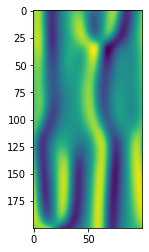

In [8]:
plt.imshow(prediction[:200])

In [9]:
f = jax.jit(lambda: model.apply(params, data_train, method=model.train_kernel)[0])
f()

DeviceArray([[ 0.60640585,  0.61151636,  0.6118308 , ..., -0.01088944,
              -0.01329822, -0.01613138],
             [ 0.61151636,  0.6199425 ,  0.6230434 , ..., -0.01633611,
              -0.01896527, -0.02206979],
             [ 0.6118308 ,  0.6230434 ,  0.62858725, ..., -0.02022448,
              -0.0230303 , -0.02635325],
             ...,
             [-0.01088944, -0.01633611, -0.02022448, ...,  0.59040874,
               0.59039456,  0.5900205 ],
             [-0.01329822, -0.01896527, -0.0230303 , ...,  0.59039456,
               0.59103835,  0.5912999 ],
             [-0.01613138, -0.02206979, -0.02635325, ...,  0.5900205 ,
               0.5912999 ,  0.59218425]], dtype=float32)

In [10]:
%%timeit
f().block_until_ready()

174 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
